# 모델 검증 (Model Validation)

In [1]:
import os
# 상위 폴더로 이동
os.chdir('..')

In [4]:
from data_presets import ClassificationPresetEval
from torchvision.transforms.functional import InterpolationMode
from datasets import load_from_disk
from transformers import AutoModelForImageClassification
from image_utils import run_model, get_metric_from_df, plot_rocauc_from_df, plot_cm_from_df, create_hook, get_embedding_layer

In [5]:
# config parameter 설정
config = {
    "model_dir" : '/workspace/model/hugginface_image_classifcation/cifar100_facebook_convnext-small-224/convnext-small-224_20241021_0247/best.hf',
    "dataset_dir" : '/workspace/model/hugginface_image_classifcation/data/hfdataset/test',
}

## 1. 데이터셋 로드 및 전처리

모델을 검증하기 위해서는 우선적으로 테스트 데이터셋을 로드하고, 해당 데이터에 대해 전처리를 수행해야 합니다. 이번 강의에서는 `load_from_disk` 함수를 사용하여 사전에 준비된 데이터셋을 로드하고, 이를 모델에 맞게 변환하는 과정을 다룹니다.

### 데이터셋 로드
먼저 데이터셋의 디렉토리를 설정하고 로드합니다. 여기서는 Huggingface `datasets` 라이브러리를 이용하여 `load_from_disk` 함수를 통해 데이터를 가져옵니다.

테스트 데이터셋에서의 라벨 정보는 추후 분석과 평가를 위해 중요한 역할을 합니다. 우리는 각 라벨에 대해 label2id, id2label을 정의하여, 라벨과 해당 id 간의 매핑을 설정합니다.

In [8]:
dataset = load_from_disk(config['dataset_dir'])
labels = dataset['test'].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [9]:
model = AutoModelForImageClassification.from_pretrained(
            config['model_dir'],
            label2id=label2id,
            id2label=id2label,
            ignore_mismatched_sizes = True, 
        )

### 이미지 전처리

테스트 데이터셋에 포함된 이미지를 모델에 입력할 수 있는 형태로 변환하기 위해 전처리가 필요합니다. 여기서는 ClassificationPresetEval 클래스와 이미지 크기 조정, 색상 변환 등의 작업을 통해 이를 수행합니다.

In [10]:
def preprocess_valid(batch, valid_transforms):
    """Apply train_transforms across a batch."""
    if "image" in batch:
        batch["pixel_values"] = [
            valid_transforms(image.convert("RGB")) for image in batch["image"]
    ]
    return batch

valid_transform = ClassificationPresetEval(
            crop_size=224,
            resize_size=256,
            interpolation=InterpolationMode.BILINEAR,
            use_v2=True,
        )

이미지를 변환하기 위한 구체적인 과정을 정의한 후, 데이터셋에 변환 함수를 적용하여 모든 이미지를 모델이 처리할 수 있는 형태로 준비합니다.

In [11]:
valid_ds = dataset['test']
valid_ds.set_transform(lambda batch: preprocess_valid(batch, valid_transform))

## 2. 모델 실행 및 결과 분석
이제 준비된 데이터셋을 바탕으로 모델을 실행하여 결과를 얻습니다. 이때 모델 디렉토리와 필요한 설정을 함께 사용합니다. 추후 t-sne 분석을 위해 훅을 사용해서 embedding layer 부분을 추출하겠습니다.

In [13]:
hook, embedding_outputs = create_hook()
embedding = get_embedding_layer(model)
hook_handle = embedding.register_forward_hook(hook)

In [14]:
# valid_df = run_model(config['model_dir'], valid_ds, id2label)

valid_df = run_model(model, valid_ds, id2label)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


### 평가 지표 산출
모델이 예측한 결과를 바탕으로 성능을 평가할 수 있는 다양한 지표들을 확인할 수 있습니다. 여기서는 get_metric_from_df 함수를 사용하여 정확도, F1 점수, AUC 등의 지표를 계산합니다.

In [ ]:
get_metric_from_df(valid_df)

{'accuracy': 0.8424,
 'top2_accuracy': 0.9314,
 'precision': 0.8466254533328962,
 'recall': 0.8423999999999999,
 'f1_score': 0.8419621232706703,
 'roc_auc': 0.9980364698989899,
 'specificity': 0.9984080808080809}

### ROC 곡선 시각화
모델의 성능을 더 깊이 이해하기 위해서는 ROC 곡선을 확인하는 것이 유용합니다. ROC 곡선은 분류 모델이 예측한 확률값과 실제 라벨을 비교하여 민감도와 특이도의 관계를 보여줍니다. 전체 지표를 보면 매우 어려우니 상위 10개, 하위 10개의 지표를 볼 것입니다.

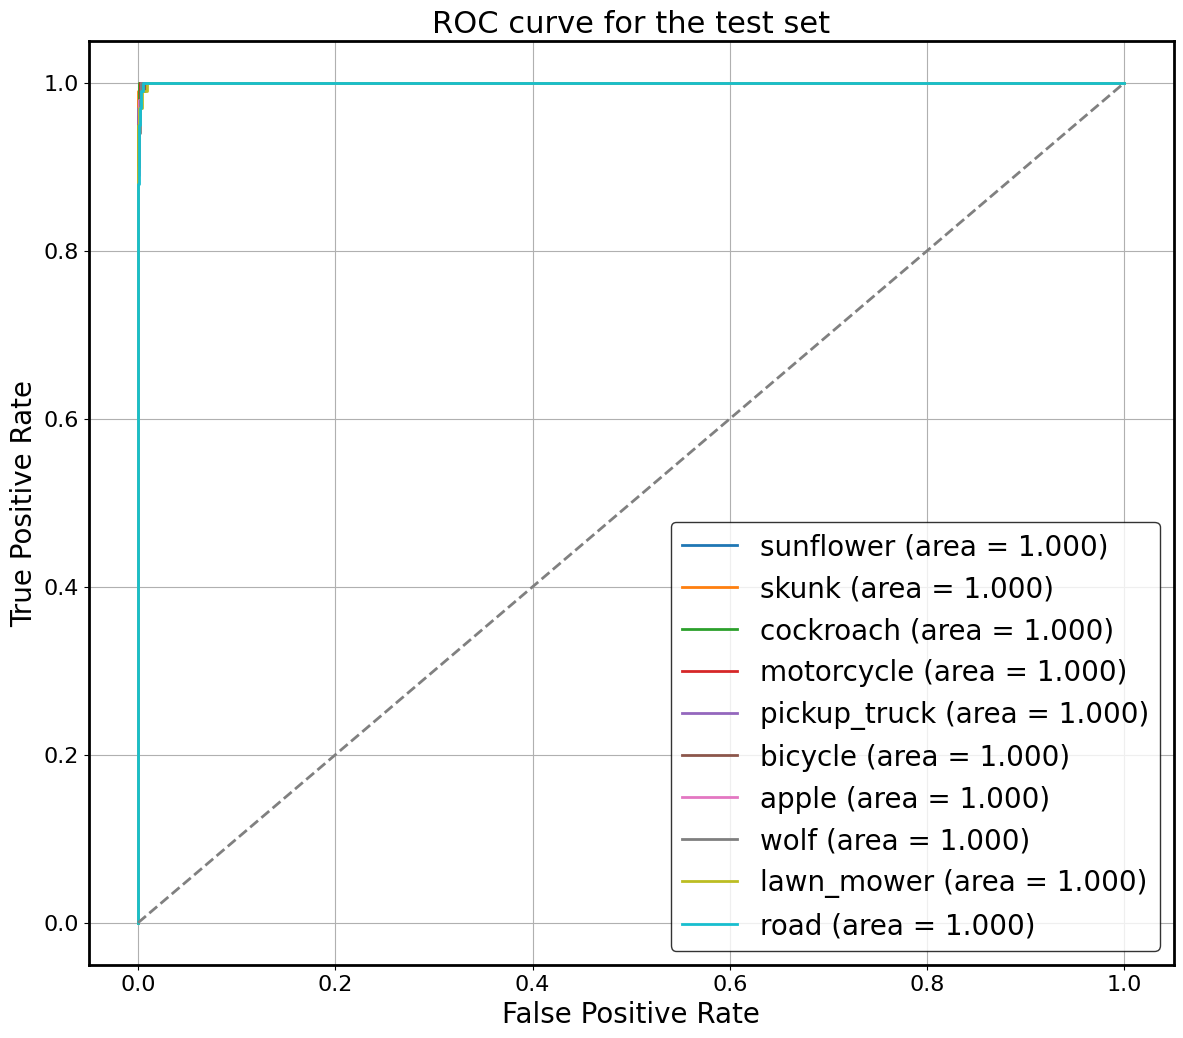

[('sunflower', 0.9999767676767677),
 ('skunk', 0.9999575757575757),
 ('cockroach', 0.9999444444444444),
 ('motorcycle', 0.9999252525252524),
 ('pickup_truck', 0.999920202020202),
 ('bicycle', 0.9998747474747474),
 ('apple', 0.999838383838384),
 ('wolf', 0.9998050505050504),
 ('lawn_mower', 0.9997919191919192),
 ('road', 0.9997747474747475)]

In [ ]:
plot_rocauc_from_df(valid_df, label2id, n=10, plot_top=True, plot_name='ROC curve for the test set')

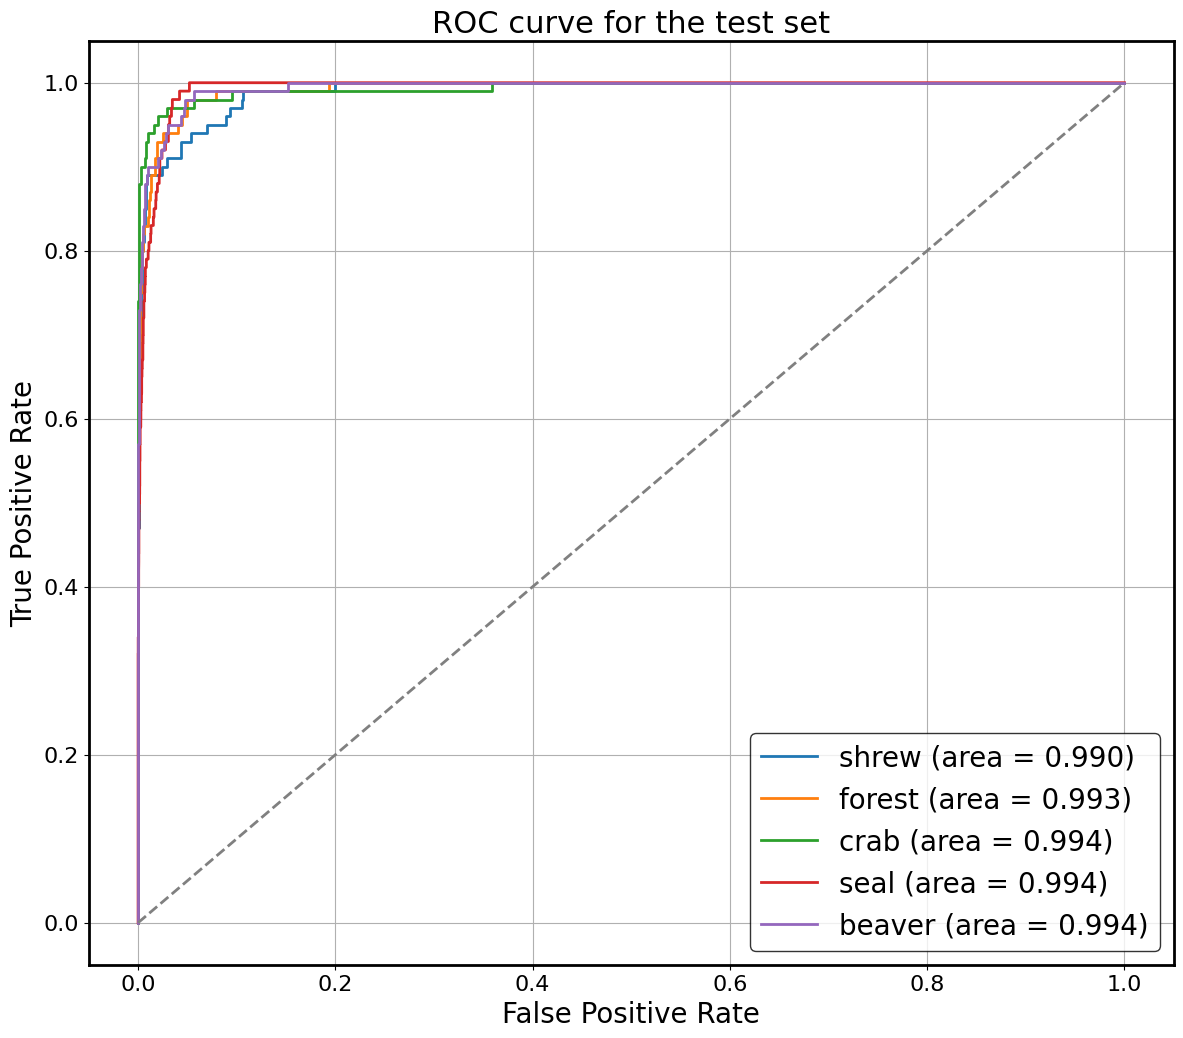

[('shrew', 0.9901636363636364),
 ('forest', 0.9930272727272726),
 ('crab', 0.9936353535353535),
 ('seal', 0.9936429292929292),
 ('beaver', 0.9942090909090909)]

In [ ]:
plot_rocauc_from_df(valid_df, label2id, n=5, plot_top=False, plot_name='ROC curve for the test set')

### 혼동 행렬 (Confusion Matrix)

마지막으로, 모델의 성능을 분석하는 또 하나의 방법으로 혼동 행렬을 시각화할 수 있습니다. 혼동 행렬은 모델이 예측한 값과 실제 라벨 간의 관계를 시각적으로 나타냅니다.

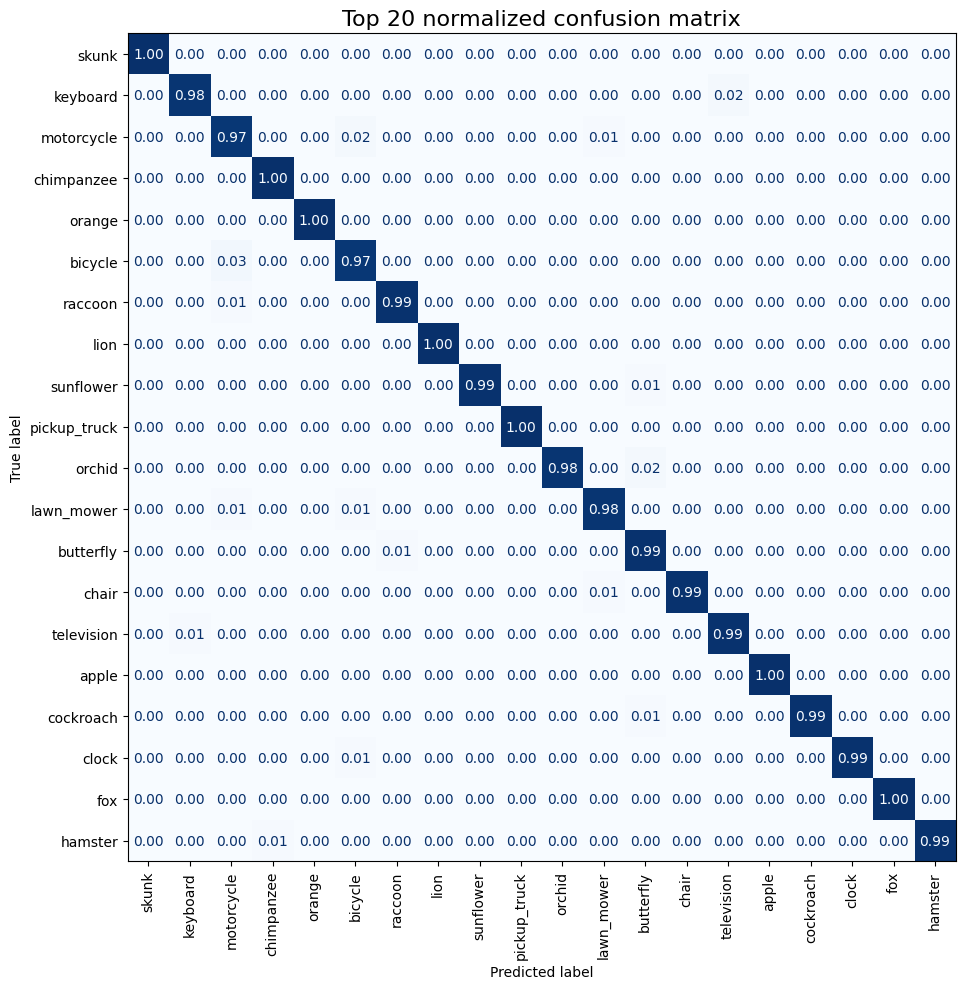

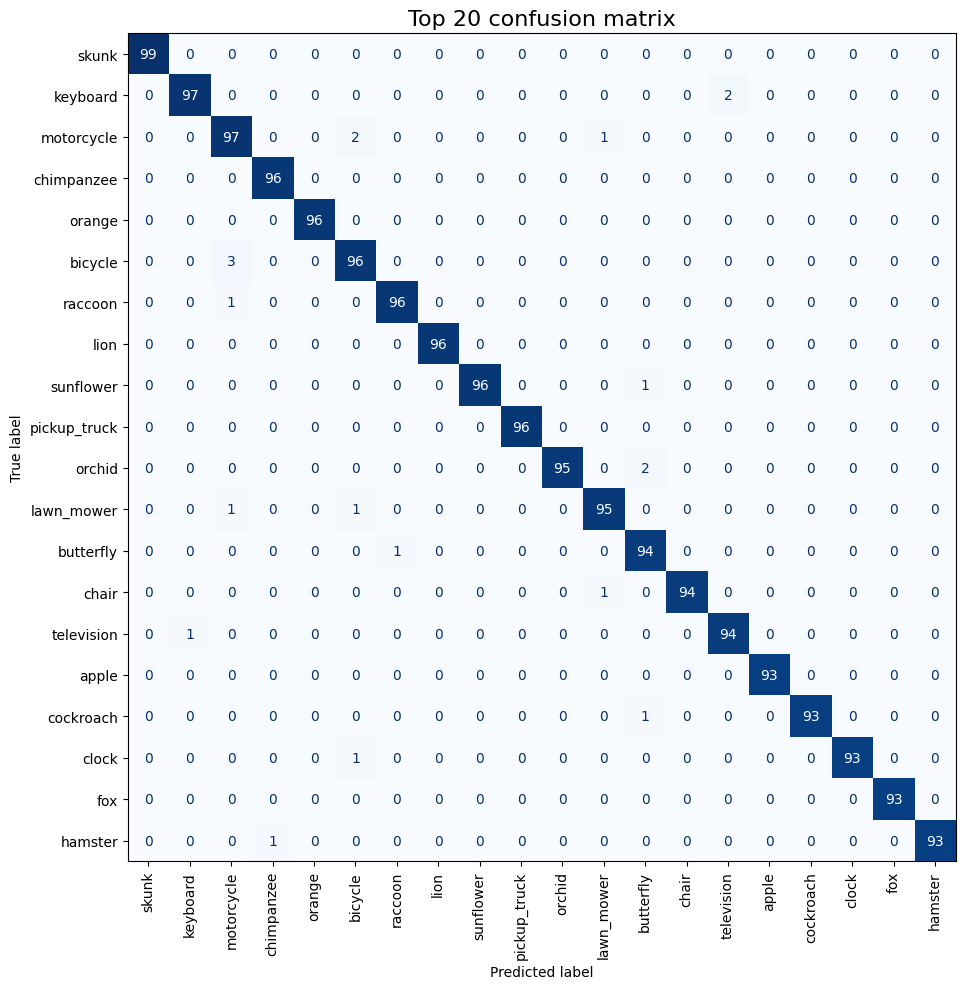

In [ ]:
plot_cm_from_df(valid_df, n=20, plot_top=True)

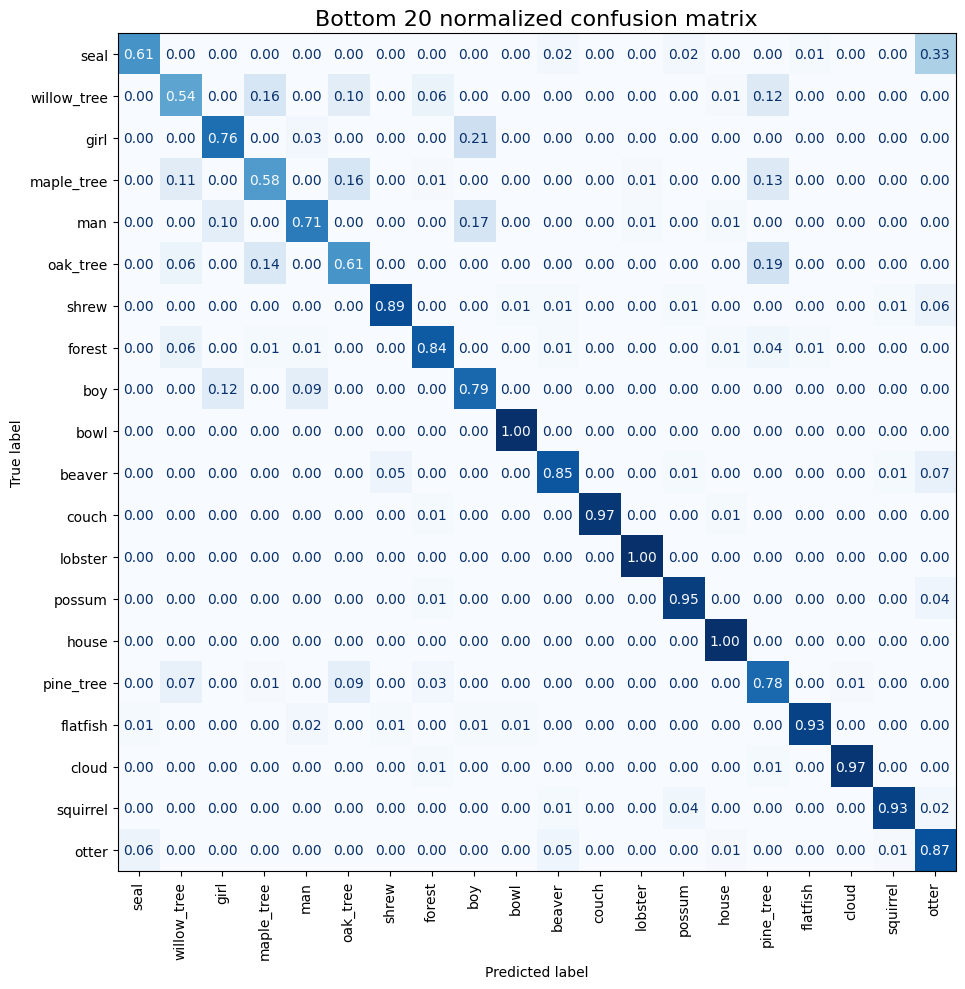

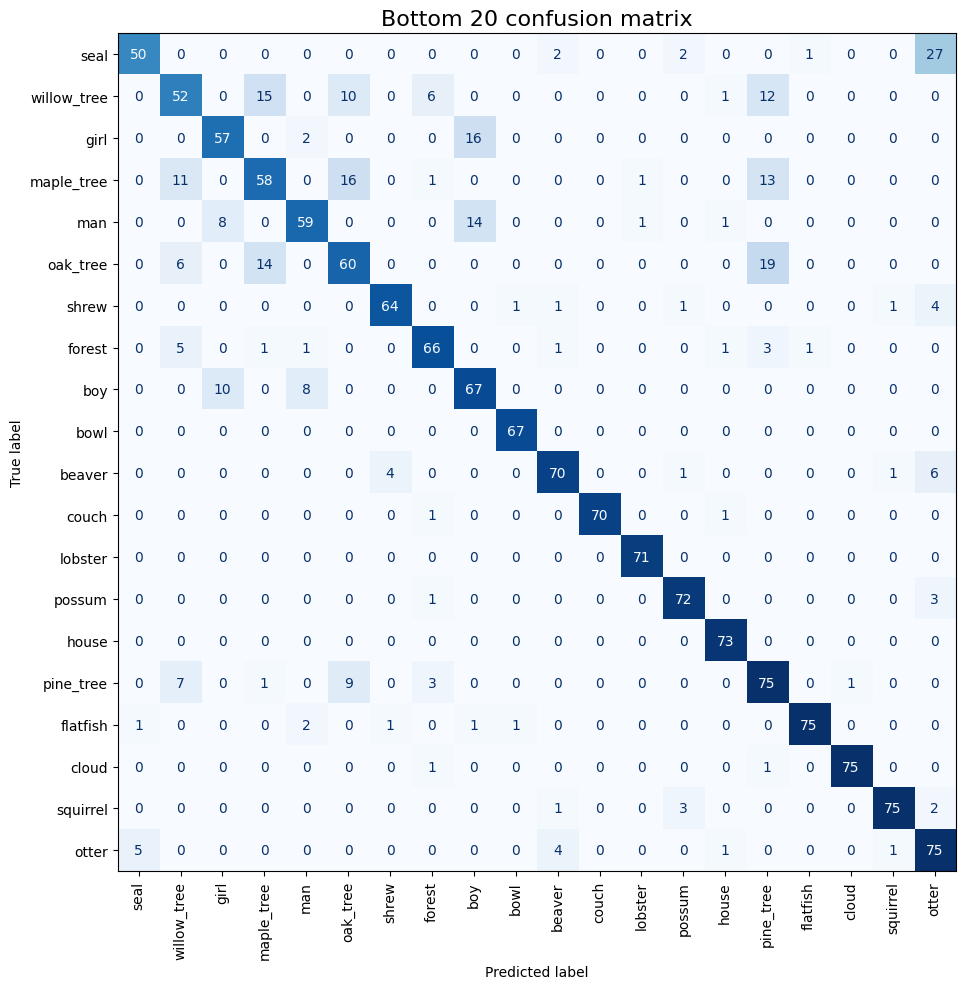

In [ ]:
plot_cm_from_df(valid_df, n=20, plot_top=False)

## Gradcam 분석

In [9]:
import gradcam_utils
from transformers import AutoModelForImageClassification

In [14]:
image = valid_ds[0]['image']
img_tensor = valid_transform(image)
label = id2label[valid_ds[0]['label']]

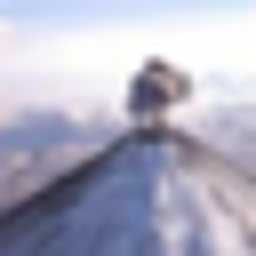

In [39]:
image

In [58]:
valid_df

,willow_tree,sweet_pepper,trout,tractor,worm,forest,dolphin,hamster,woman,cockroach,...,rose,squirrel,snail,lamp,cup,can,whale,label,encoded_label,pred_label
0,0.000143,0.000070,0.000291,0.000265,0.000050,0.015180,0.001559,0.000454,0.000217,0.000087,...,0.000099,0.000124,0.000146,0.000680,0.000026,0.000083,0.000647,mountain,49,mountain
1,0.000007,0.000005,0.000009,0.000010,0.000004,0.001606,0.000079,0.000007,0.000005,0.000006,...,0.000004,0.000001,0.000002,0.000007,0.000005,0.000008,0.000064,mountain,49,mountain
2,0.000006,0.000007,0.000028,0.000019,0.000013,0.000472,0.000623,0.000007,0.000007,0.000004,...,0.000007,0.000004,0.000007,0.000016,0.000014,0.000009,0.000581,mountain,49,mountain
3,0.001321,0.000037,0.000373,0.000650,0.000072,0.110949,0.000161,0.000068,0.000050,0.000125,...,0.000067,0.000073,0.000035,0.000045,0.000019,0.000109,0.000215,mountain,49,mountain
4,0.035414,0.000114,0.000149,0.000196,0.000044,0.173805,0.000261,0.000198,0.000418,0.000071,...,0.000269,0.000191,0.000092,0.000749,0.000190,0.000123,0.000050,mountain,49,mountain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.000022,0.000007,0.000003,0.000037,0.000032,0.000148,0.000004,0.000014,0.000007,0.000005,...,0.000009,0.000010,0.000004,0.000004,0.000004,0.000008,0.000004,tiger,88,tiger
9996,0.000011,0.000008,0.000002,0.000027,0.000012,0.000044,0.000004,0.000008,0.000008,0.000005,...,0.000009,0.000007,0.000007,0.000005,0.000010,0.000009,0.000008,tiger,88,tiger
9997,0.000031,0.000008,0.000003,0.000035,0.000014,0.000063,0.000003,0.000044,0.000009,0.000004,...,0.000010,0.000018,0.000008,0.000006,0.000021,0.000015,0.000004,tiger,88,tiger
9998,0.000029,0.000006,0.000002,0.000019,0.000035,0.000168,0.000011,0.000008,0.000003,0.000003,...,0.000006,0.000010,0.000007,0.000005,0.000010,0.000013,0.000011,tiger,88,tiger


In [57]:
valid_df['pred_label'] = valid_df.drop(columns=['encoded_label', 'label']).idxmax(axis=1)

In [63]:
mismatch_df = valid_df[valid_df['label'] != valid_df['pred_label']]
mismatch_df.sample(20)

,willow_tree,sweet_pepper,trout,tractor,worm,forest,dolphin,hamster,woman,cockroach,...,rose,squirrel,snail,lamp,cup,can,whale,label,encoded_label,pred_label
88,7.846810e-04,0.000024,0.000044,2.094128e-05,0.000016,1.276504e-03,0.000011,0.000022,0.000015,0.000014,...,0.000007,0.000009,0.000002,0.000005,0.000013,0.000005,2.782028e-05,mountain,49,plain
297,2.668643e-04,0.000047,0.009657,1.355372e-04,0.000093,1.710334e-04,0.000488,0.000253,0.002679,0.000140,...,0.000083,0.000074,0.001087,0.000274,0.000246,0.000205,2.850462e-04,seal,72,flatfish
2869,1.664620e-05,0.000108,0.000097,7.797908e-06,0.000400,9.890224e-05,0.088267,0.000046,0.000251,0.000157,...,0.000324,0.000014,0.000176,0.000173,0.000236,0.000070,5.955040e-01,shark,73,whale
2831,8.282767e-07,0.000011,0.000026,9.054326e-07,0.000009,7.583997e-07,0.042292,0.000079,0.000059,0.000032,...,0.000001,0.000001,0.000008,0.000042,0.000041,0.000009,9.525311e-01,shark,73,whale
7459,3.080324e-06,0.000003,0.000025,2.113808e-05,0.000010,2.897402e-06,0.000007,0.468203,0.000166,0.000012,...,0.000004,0.000318,0.000005,0.000009,0.000018,0.000014,4.587394e-06,possum,64,hamster
6063,2.943911e-05,0.000015,0.000019,2.871232e-05,0.000046,1.076903e-05,0.000037,0.000005,0.000009,0.000028,...,0.000009,0.000002,0.000010,0.000089,0.000013,0.000024,5.067216e-05,bus,13,pickup_truck
4910,2.426821e-05,0.000011,0.000069,3.170368e-05,0.000019,7.329974e-05,0.000031,0.001786,0.002810,0.000212,...,0.000049,0.000108,0.000167,0.000085,0.000032,0.000166,7.141356e-06,girl,35,boy
886,5.897539e-04,0.000033,0.000026,4.528360e-05,0.000030,1.107888e-03,0.000017,0.000063,0.000012,0.000014,...,0.000035,0.000019,0.000003,0.000021,0.000033,0.000005,6.979045e-05,cloud,23,plain
3246,1.936910e-05,0.000004,0.000002,1.164343e-03,0.000002,4.052277e-05,0.000006,0.000006,0.000002,0.000005,...,0.000007,0.000002,0.000006,0.000123,0.000003,0.000012,9.419589e-07,house,37,streetcar
6140,1.063163e-03,0.000340,0.001179,6.384572e-04,0.000239,3.216651e-04,0.000042,0.008434,0.000093,0.000076,...,0.000360,0.000847,0.000300,0.000174,0.000057,0.000070,3.775340e-05,mouse,50,raccoon


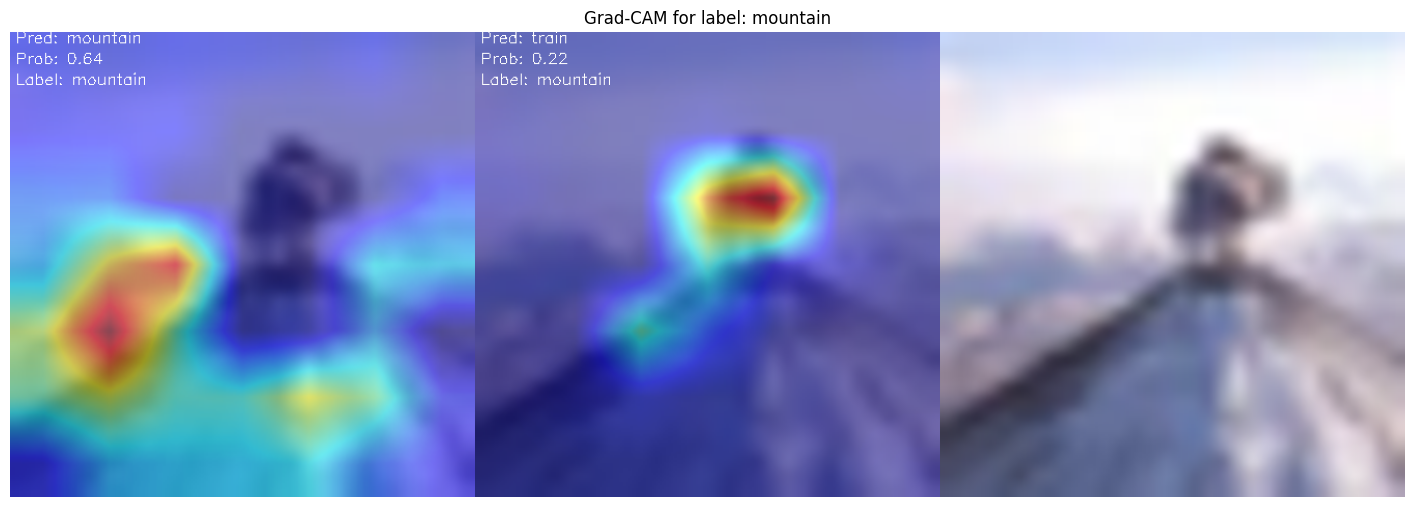

In [40]:
gradcam_utils.gradcam_one_image(image, label, model, img_tensor, val_crop_size=224, save_image=False)

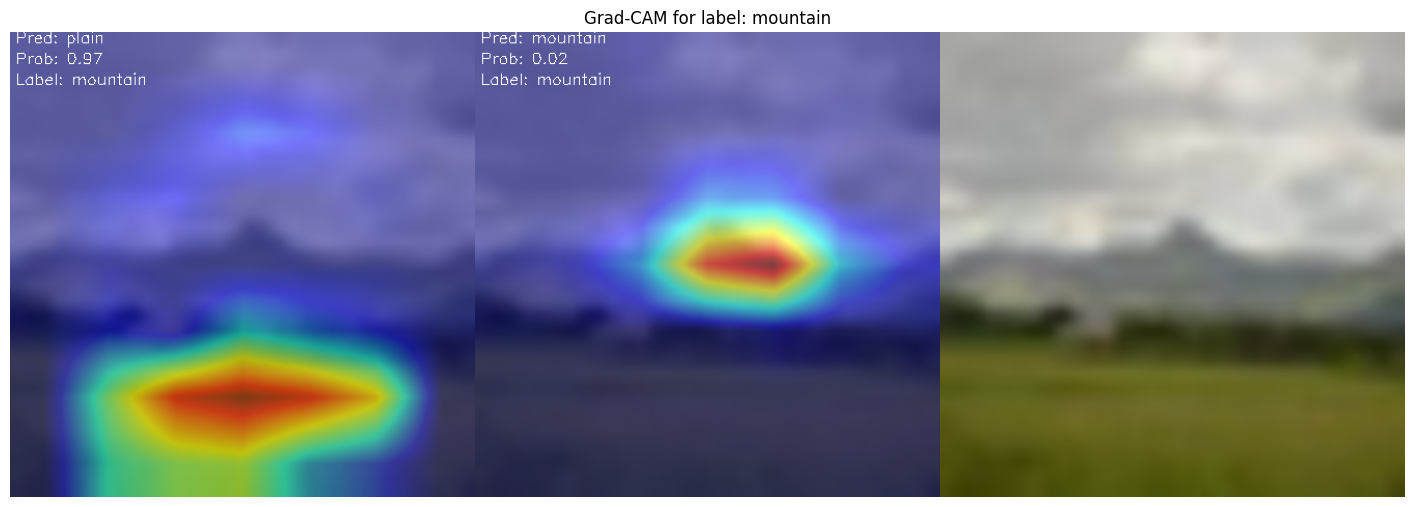

In [68]:
image = valid_ds[88]['image']
img_tensor = valid_transform(image)
label = id2label[valid_ds[88]['label']]
gradcam_utils.gradcam_one_image(image, label, model, img_tensor, val_crop_size=224, save_image=False)

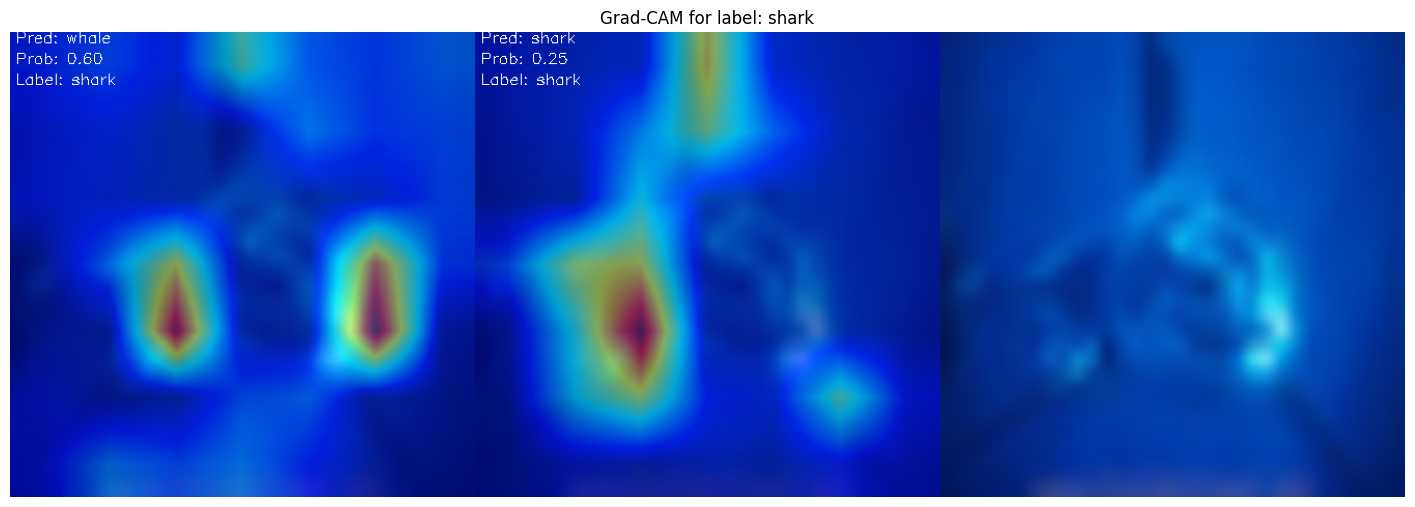

In [67]:
image = valid_ds[2869]['image']
img_tensor = valid_transform(image)
label = id2label[valid_ds[2869]['label']]
gradcam_utils.gradcam_one_image(image, label, model, img_tensor, val_crop_size=224, save_image=False)

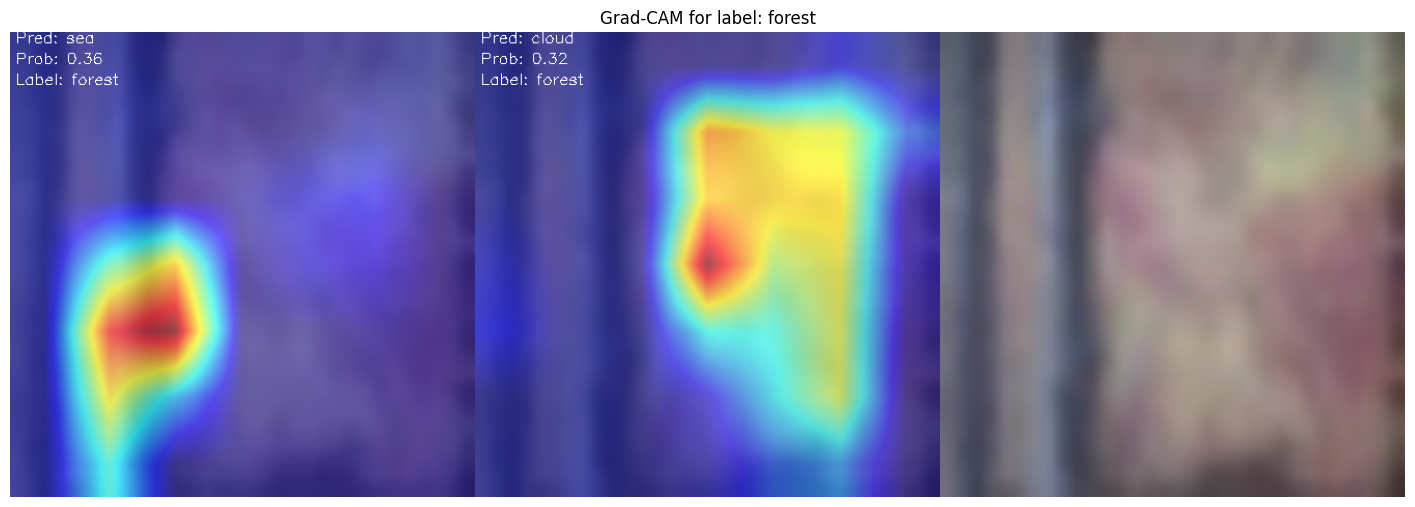

In [69]:
image = valid_ds[115]['image']
img_tensor = valid_transform(image)
label = id2label[valid_ds[115]['label']]
gradcam_utils.gradcam_one_image(image, label, model, img_tensor, val_crop_size=224, save_image=False)

## t-sne 분석

In [71]:
from image_utils import create_hook, get_embedding_layer, check_embedding, save_umap

In [15]:
valid_df

,willow_tree,sweet_pepper,trout,tractor,worm,forest,dolphin,hamster,woman,cockroach,...,dinosaur,rose,squirrel,snail,lamp,cup,can,whale,label,encoded_label
0,0.000143,0.000070,0.000291,0.000265,0.000050,0.015180,0.001559,0.000454,0.000217,0.000087,...,0.000975,0.000099,0.000124,0.000146,0.000680,0.000026,0.000083,0.000647,mountain,63
1,0.000007,0.000005,0.000009,0.000010,0.000004,0.001606,0.000079,0.000007,0.000005,0.000006,...,0.000019,0.000004,0.000001,0.000002,0.000007,0.000005,0.000008,0.000064,mountain,63
2,0.000006,0.000007,0.000028,0.000019,0.000013,0.000472,0.000623,0.000007,0.000007,0.000004,...,0.000052,0.000007,0.000004,0.000007,0.000016,0.000014,0.000009,0.000581,mountain,63
3,0.001321,0.000037,0.000373,0.000650,0.000072,0.110949,0.000161,0.000068,0.000050,0.000125,...,0.000475,0.000067,0.000073,0.000035,0.000045,0.000019,0.000109,0.000215,mountain,63
4,0.035414,0.000114,0.000149,0.000196,0.000044,0.173805,0.000261,0.000198,0.000418,0.000071,...,0.000219,0.000269,0.000191,0.000092,0.000749,0.000190,0.000123,0.000050,mountain,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.000022,0.000007,0.000003,0.000037,0.000032,0.000148,0.000004,0.000014,0.000007,0.000005,...,0.000003,0.000009,0.000010,0.000004,0.000004,0.000004,0.000008,0.000004,tiger,76
9996,0.000011,0.000008,0.000002,0.000027,0.000012,0.000044,0.000004,0.000008,0.000008,0.000005,...,0.000002,0.000009,0.000007,0.000007,0.000005,0.000010,0.000009,0.000008,tiger,76
9997,0.000031,0.000008,0.000003,0.000035,0.000014,0.000063,0.000003,0.000044,0.000009,0.000004,...,0.000006,0.000010,0.000018,0.000008,0.000006,0.000021,0.000015,0.000004,tiger,76
9998,0.000029,0.000006,0.000002,0.000019,0.000035,0.000168,0.000011,0.000008,0.000003,0.000003,...,0.000005,0.000006,0.000010,0.000007,0.000005,0.000010,0.000013,0.000011,tiger,76


In [16]:
y_valid = valid_df.drop(columns=['encoded_label', 'label']).idxmax(axis=1)

In [20]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

def show_tsne(all_embeddings, y_true, labels):
    # t-SNE 생성
    tsne = TSNE(n_components=2, perplexity=30, metric='euclidean', n_iter=1000)
    embedding = tsne.fit_transform(all_embeddings)
    
    # y_true를 숫자로 변환
    le = LabelEncoder()
    y_numeric = le.fit_transform(y_true)
    
    plt.figure(figsize=(8, 5))
    plt.scatter(embedding[:, 0], embedding[:, 1], c=y_numeric, cmap='nipy_spectral', s=8)
    plt.gca().set_aspect('equal', 'datalim')

    colorbar = plt.colorbar(boundaries=np.arange(len(labels)+1)-0.5)
    colorbar.set_ticks(np.arange(len(labels)))
    colorbar.set_ticklabels(labels)

    plt.title('t-SNE projection of the valid dataset', fontsize=12)
    plt.show() 

/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


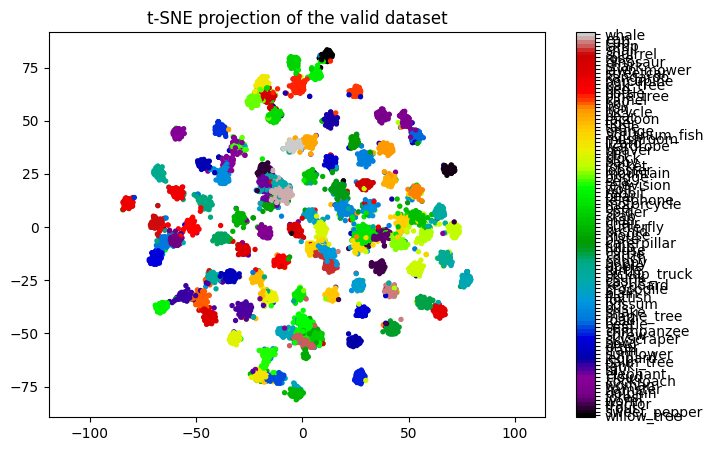

In [21]:
all_embeddings = check_embedding(model, embedding_outputs)
hook_handle.remove()
show_tsne(all_embeddings, y_valid, labels)